In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
perf_train= pd.read_csv('trainperf.csv')
perf_test= pd.read_csv('testperf.csv')

In [31]:
prev_train= pd.read_csv('trainprevloans.csv')
prev_test= pd.read_csv('testprevloans.csv')

In [32]:
perf_train['referredby']= perf_train['referredby'].fillna(value='no one')

perf_test['referredby']= perf_test['referredby'].fillna(value='no one')

In [33]:
def days(row):
    row= str(row)
    return int(row[:row.index(' ')])

In [34]:
def pay_rate(df):
    day= (pd.to_datetime(df['closeddate'])-pd.to_datetime(df['approveddate'])).apply(days)
    return df['totaldue']/day

In [35]:
prev_train['pay_rate']= pay_rate(prev_train)
prev_test['pay_rate']= pay_rate(prev_test)

In [36]:
avg_train=prev_train[['customerid', 'pay_rate']].groupby(by='customerid', as_index=False).mean()
avg_test=prev_test[['customerid', 'pay_rate']].groupby(by='customerid', as_index=False).mean()

In [37]:
all_train= perf_train.merge(avg_train, on='customerid', how='left')
all_test= perf_test.merge(avg_test, on='customerid', how='left')

In [38]:
all_train['pay_rate'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
all_test['pay_rate'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

In [39]:
useless= ['customerid','systemloanid', 'approveddate', 'creationdate']
all_train.drop(useless, axis=1, inplace=True)
all_test.drop(useless, axis=1, inplace=True)

In [40]:
X= all_train.drop(['good_bad_flag'], axis=1)
Y= all_train['good_bad_flag']

In [41]:
X

,loannumber,loanamount,totaldue,termdays,referredby,pay_rate
0,12,30000.0,34500.0,30,no one,2988.835851
1,2,15000.0,17250.0,30,no one,0.000000
2,7,20000.0,22250.0,15,no one,1105.846561
3,3,10000.0,11500.0,15,no one,393.518519
4,9,40000.0,44000.0,30,no one,850.269865
...,...,...,...,...,...,...
4363,2,10000.0,13000.0,30,no one,361.111111
4364,2,10000.0,13000.0,30,no one,500.000000
4365,3,10000.0,11500.0,15,no one,596.198157
4366,2,10000.0,13000.0,30,8a858eda5c8863ff015c9dead65807bb,433.333333


In [42]:
from sklearn.model_selection import train_test_split

In [43]:
x_train,x_test ,y_train, y_test= train_test_split(X,Y, test_size=0.1, random_state=0)

In [44]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)



In [45]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numerical_preprocessor = RobustScaler()


categorical_preprocessor= OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer([
    ('ordinal-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])

In [46]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, cross_val_score
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

In [47]:
def crs_val(algo):
  # run block of code and catch warnings
  import warnings
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    cv= StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2)
    model= Pipeline(steps=[('scale', preprocessor), ('sample', SMOTE(random_state=42)), ('model', algo)])
    result= cross_validate(model, x_train, y_train, cv=cv, scoring='accuracy', return_train_score=False)
    #print(result)
    return result['test_score']

In [48]:
algos= {'LogisticRegression':LogisticRegression(max_iter=2000),
       'RandomForestClassifier': RandomForestClassifier(random_state=0),
       'BaggingClassifier':AdaBoostClassifier(base_estimator=LogisticRegression(),random_state=0),
       'LGBMClassifier': LGBMClassifier(random_state=0),
       #'XGBClassifier': XGBClassifier(random_state=0),
       'ExtraTreesClassifier': ExtraTreesClassifier(random_state=0)
       }
for alg in algos.keys():
    score= crs_val(algos[alg])
    print(alg+': \n',score.mean(), ' +/- ',score.std())

LogisticRegression: 
 0.5212198221092756  +/-  0.015424641327058236
RandomForestClassifier: 
 0.6842439644218551  +/-  0.0072827089610709534
BaggingClassifier: 
 0.5430749682337993  +/-  0.012835432070317048
LGBMClassifier: 
 0.6907242693773824  +/-  0.014185805069329448
ExtraTreesClassifier: 
 0.6799237611181702  +/-  0.009010856747899072


In [ ]:
""" LogisticRegression: 
 0.5040660736975858  +/-  0.0321654704572391
RandomForestClassifier: 
 0.6161372299872936  +/-  0.017601571294498478
BaggingClassifier: 
 0.5318932655654385  +/-  0.02851578786673196
LGBMClassifier: 
 0.6110546378653112  +/-  0.020936408642853007
ExtraTreesClassifier: 
 0.6130876747141041  +/-  0.01759973665083138 """

In [98]:
from scipy.stats import loguniform


class loguniform_odd_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b//2)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return -1+ 2*self._distribution.rvs(*args, **kwargs).astype(int)
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [99]:
print(loguniform_int(1, 10).rvs())

2


In [103]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
model= Pipeline(steps=[('scale', preprocessor), ('sample', SMOTE(random_state=42, )), ('classifier', LGBMClassifier(random_state=0))])
cv= StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.22)
param_grid = {
    'classifier__n_estimators': loguniform_int(100,1000),
    'sample__k_neighbors':loguniform_odd_int(1, 50)
}
model_grid_search = RandomizedSearchCV(
    model, param_distributions=param_grid, n_jobs=-1, cv=cv, n_iter=20, random_state=0
)
model_grid_search.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.22,
            train_size=None),
                   estimator=Pipeline(steps=[('scale',
                                              ColumnTransformer(transformers=[('ordinal-encoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['referredby']),
                                                                              ('standard-scaler',
                                                                               RobustScaler(),
                                                                               ['loannumber',
                                                                                'loanamount',
                                                                                'totaldue',
                                      

In [104]:
cv_results = pd.DataFrame(model_grid_search.cv_results_)
cv_results[[
    "param_classifier__n_estimators",
    "param_sample__k_neighbors",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]]

,param_classifier__n_estimators,param_sample__k_neighbors,mean_test_score,std_test_score,rank_test_score
0,353,17,0.705896,0.012782,9
1,400,9,0.695260,0.015887,15
2,265,13,0.704740,0.018082,10
3,273,33,0.720116,0.010242,5
4,919,5,0.681734,0.014886,19
5,619,9,0.692139,0.014384,17
6,369,37,0.720347,0.009911,4
7,117,1,0.675029,0.016757,20
8,104,27,0.728208,0.013125,2
9,600,31,0.704509,0.019040,11


In [105]:
cv_results = cross_validate(
    model_grid_search, X, Y, cv=cv, n_jobs=-1, return_estimator=True
)

In [106]:
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.734 +/- 0.007


In [107]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'classifier__n_estimators': 139, 'sample__k_neighbors': 39}
Best hyperparameters for fold #2:
{'classifier__n_estimators': 139, 'sample__k_neighbors': 39}
Best hyperparameters for fold #3:
{'classifier__n_estimators': 104, 'sample__k_neighbors': 27}
Best hyperparameters for fold #4:
{'classifier__n_estimators': 104, 'sample__k_neighbors': 27}
Best hyperparameters for fold #5:
{'classifier__n_estimators': 139, 'sample__k_neighbors': 39}
Best hyperparameters for fold #6:
{'classifier__n_estimators': 139, 'sample__k_neighbors': 39}
Best hyperparameters for fold #7:
{'classifier__n_estimators': 104, 'sample__k_neighbors': 27}
Best hyperparameters for fold #8:
{'classifier__n_estimators': 139, 'sample__k_neighbors': 39}
Best hyperparameters for fold #9:
{'classifier__n_estimators': 139, 'sample__k_neighbors': 39}
Best hyperparameters for fold #10:
{'classifier__n_estimators': 104, 'sample__k_neighbors': 27}


In [109]:
models=cv_results.sort_values(by='test_score', ascending=False)
models

,fit_time,score_time,estimator,test_score
0,302.774248,0.132998,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.745057
1,302.926252,0.064000,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.744017
5,314.497053,0.111000,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.740895
7,316.034895,0.147999,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.735692
9,151.485552,0.028023,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.734651
2,304.222065,0.143663,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.733611
3,303.022250,0.059005,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.727367
4,314.801060,0.079998,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.727367
6,313.922063,0.056996,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.727367
8,151.071981,0.055772,RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.726327


In [110]:
pred=models["estimator"][0].predict(all_test)

(array([1177.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         273.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

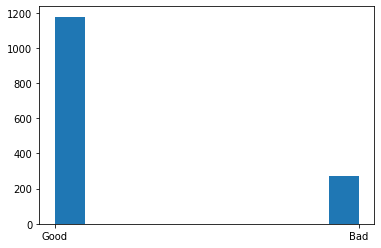

In [111]:
plt.hist(pred)

In [112]:
def submit():
    import datetime
    sub= pd.read_csv('SampleSubmission.csv')
    sub['good_bad_flag']=pred
    moment=datetime.datetime.now().strftime('%m%d%H%M%S')
    #print(moment)
    sub.to_csv(moment+'.csv', index=False)
    print(moment)
submit()

0323080647
